In [1]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Dataset

- csv file
- It is a variation of the Sentiment140 dataset, which contains 1.6 million tweets alongside their respective sentiment (0 for negative and 4 for positive)
- Since it is huge, 
    - We need only first and last elements => target: the polarity of the tweet (0 = negative, 4 = positive), text
    - We use only 10% of the data

In [ ]:
# Load dataset
df = pd.read_csv('Datasets/training_cleaned.csv',header=None)
display(df.head())

labels_all = df.iloc[:,0].values
sentences_all = df.iloc[:,-1].values
print(labels_all.shape,labels_all.dtype)
print(sentences_all.shape,sentences_all.dtype)

print(sentences_all[1])

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


(1600000,) int64
(1600000,) object
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!


In [ ]:
sentences, sentences_ignore, labels, labels_ignore = train_test_split(sentences_all, labels_all, train_size = 0.1)
print(sentences.shape)

sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences,labels,test_size=0.1)
sentences_train = np.array(sentences_train)
labels_train = np.array(labels_train)
sentences_val = np.array(sentences_val)
labels_val = np.array(labels_val)
print("Train => ",sentences_train.shape,labels_train.shape)
print("Val => ",sentences_val.shape,labels_val.shape)

(160000,)
Train =>  (144000,) (144000,)
Val =>  (16000,) (16000,)


In [ ]:
print("Labels => ",np.unique(labels_train),np.unique(labels_val))

#Replace 4 with 1 in both datasets
labels_train[labels_train == 4] = 1
labels_val[labels_val == 4] = 1
print("Replaced Labels => ",np.unique(labels_train),np.unique(labels_val))

Labels =>  [0 4] [0 4]
Replaced Labels =>  [0 1] [0 1]


In [ ]:
def plot_graphs(model_hist, string):
  plt.plot(model_hist.history[string])
  plt.plot(model_hist.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Text preprocessing

In [ ]:
vec_layer_sentence = tf.keras.layers.TextVectorization(output_mode='int',output_sequence_length=16)

vec_layer_sentence.adapt(sentences_train)
vectorized_sentences_train = vec_layer_sentence(sentences_train)
vectorized_sentences_val = vec_layer_sentence(sentences_val)
print(vec_layer_sentence.vocabulary_size())
print(vectorized_sentences_train)
print(vectorized_sentences_val.shape)

146210
tf.Tensor(
[[ 21461      8     36 ...      0      0      0]
 [100149    197    296 ...      0      0      0]
 [    56    136      2 ...      0      0      0]
 ...
 [ 49704    201     23 ...      0      0      0]
 [ 42578      2     62 ...     21     45  55785]
 [    64      5     96 ...    106      0      0]], shape=(144000, 16), dtype=int64)
(16000, 16)


## Pre-defined Word Embeddings

- https://nlp.stanford.edu/projects/glove/
- We use the downloaded GloVe embeddings to create an embedding matrix, where the rows contain the word embeddings for the tokens in the Vector layer's vocabulary.

In [ ]:
# Define path to file containing the embeddings
GLOVE_FILE = 'Datasets/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

test_word = 'hello'
test_vector = GLOVE_EMBEDDINGS[test_word]
print("Vector representation of ",test_word,":\n\n",test_vector)
print("Each word vector has shape = ",test_vector.shape)

Vector representation of  hello :

 [ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.27326    0.1563

In [ ]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vec_layer_sentence.vocabulary_size(),100)) #EMBEDDING_DIM = 100

# Iterate all the words in the vocabulary and if the vector representation for
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
i = 0
for word in vec_layer_sentence.get_vocabulary():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector
    i += 1

## Model

In [ ]:
sentences_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vec_layer_sentence.vocabulary_size(),output_dim=100,input_length=16,
                              trainable=False,
                              weights=[EMBEDDINGS_MATRIX]), 
    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=64,kernel_size=5,activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128,return_sequences=True)), #activation='tanh'
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)), #activation='tanh'

    tf.keras.layers.Dense(units=32,activation='relu'),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

sentences_model.compile(optimizer='adam',
                                   loss='binary_crossentropy',
                                   metrics=['accuracy'])

sentences_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           14621000  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 12, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 64)            0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4

In [ ]:
sentences_model_hist = sentences_model.fit(x=vectorized_sentences_train, y=labels_train,
                                           epochs=20,
                                           validation_data=(vectorized_sentences_val,labels_val))

Epoch 1/20
4500/4500 [==============================] - 32s 6ms/step - loss: 0.5636 - accuracy: 0.7032 - val_loss: 0.5116 - val_accuracy: 0.7421
Epoch 2/20
4500/4500 [==============================] - 31s 7ms/step - loss: 0.5182 - accuracy: 0.7387 - val_loss: 0.4994 - val_accuracy: 0.7524
Epoch 3/20
4500/4500 [==============================] - 28s 6ms/step - loss: 0.5007 - accuracy: 0.7512 - val_loss: 0.4927 - val_accuracy: 0.7585
Epoch 4/20
4500/4500 [==============================] - 27s 6ms/step - loss: 0.4868 - accuracy: 0.7595 - val_loss: 0.4969 - val_accuracy: 0.7562
Epoch 5/20
4500/4500 [==============================] - 28s 6ms/step - loss: 0.4777 - accuracy: 0.7658 - val_loss: 0.4870 - val_accuracy: 0.7588
Epoch 6/20
4500/4500 [==============================] - 26s 6ms/step - loss: 0.4702 - accuracy: 0.7711 - val_loss: 0.4950 - val_accuracy: 0.7586
Epoch 7/20
4500/4500 [==============================] - 28s 6ms/step - loss: 0.4628 - accuracy: 0.7756 - val_loss: 0.4913 - val_ac

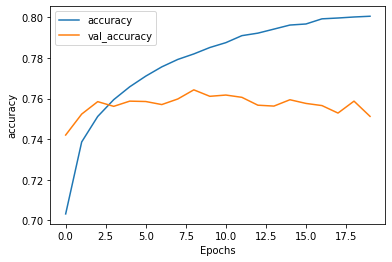

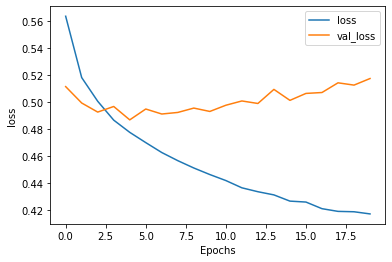

In [ ]:
plot_graphs(sentences_model_hist, "accuracy")
plot_graphs(sentences_model_hist, "loss")